### Imports & Downloads

In [5]:
!pip install opendatasets --upgrade --quiet
!pip install -q streamlit

In [4]:
import os
import opendatasets as od
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

ModuleNotFoundError: No module named 'torch'

In [ ]:
od.download("https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda")

### Preparing the dataset


In [4]:
dataset = ImageFolder('./animal-image-datasetdog-cat-and-panda/animals/animals')

In [5]:
dataset.classes

['cats', 'dogs', 'panda']

In [6]:
datalen = len(dataset)

test_frac, val_frac = .2 , .1
test_size = int(datalen*test_frac)
val_size = int(datalen*val_frac)
train_size = int(datalen*(1-(test_frac+val_frac)))

datalen, test_size, val_size, train_size

(3000, 600, 300, 2100)

In [7]:
random_seed = 42
torch.manual_seed(random_seed);

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

In [9]:
colour_stats = ((0.4652, 0.4393, 0.3945), (0.2763, 0.2675, 0.2653))
transforms_train = tt.Compose([
                        tt.Resize((128,128)),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(degrees=30),
                        tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                        tt.RandomCrop(96, padding=4, padding_mode='reflect'),
                        tt.ToTensor(),
                        #tt.Normalize(*colour_stats,inplace=True)
                        ])
transforms_val = tt.Compose([
                        tt.Resize((128,128)),
                        tt.RandomCrop(96, padding=4, padding_mode='reflect'),
                        tt.ToTensor(), 
                        #tt.Normalize(*colour_stats)
                        ])
transforms_test = tt.Compose([
                        tt.Resize((128,128)),
                        tt.RandomCrop(96, padding=4, padding_mode='reflect'),
                        tt.ToTensor(), 
                        #tt.Normalize(*colour_stats)
                        ])

### Setting up custom dataset

In [10]:
class AnimalsCustomDS(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, el):
        img, lbl = self.ds[el]
        if self.transform:
            img = self.transform(img)  
            return img, lbl

In [11]:
train_dataset = AnimalsCustomDS(train_ds, transform=transforms_train)
val_dataset = AnimalsCustomDS(val_ds, transform=transforms_val)
test_dataset = AnimalsCustomDS(test_ds, transform=transforms_test)

In [12]:
batch_size = 128

In [13]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(val_dataset, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1


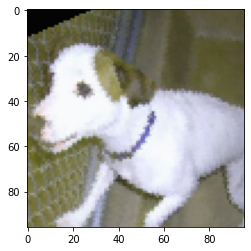

In [14]:
img, label = train_dataset[9]
print(label)
plt.imshow(img.permute(1,2,0))

In [15]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break


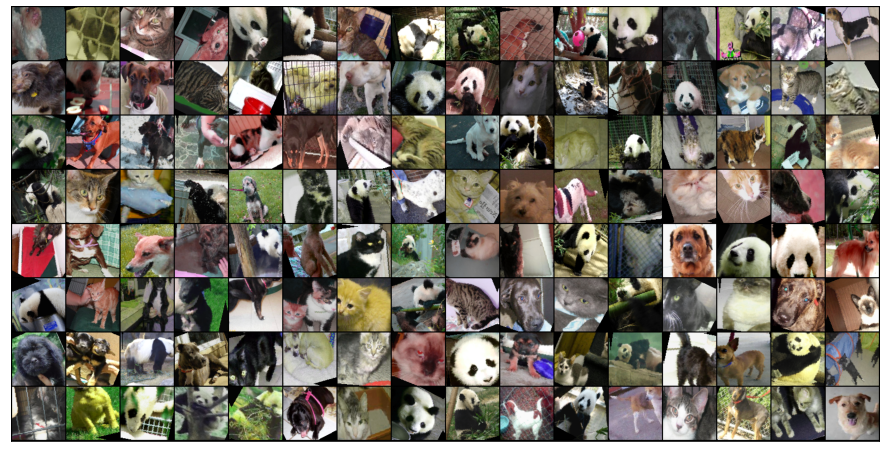

In [16]:
show_batch(train_dl)

### Switching to GPU

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [18]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [19]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

cpu


### Building the ResNet

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc , 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))


In [22]:
def cn_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

In [23]:
class ResNet(ImageClassificationBase):
  def __init__(self, in_channels, out_classes):
    super().__init__()

    self.conv1 = cn_block(in_channels, 64)
    self.conv2 = cn_block(64, 128, pool=True)
    self.res1 = nn.Sequential(cn_block(128,128),
                              cn_block(128,128))
    
    self.conv3 = cn_block(128, 256, pool=True)
    self.conv4 = cn_block(256, 512, pool=True)
    self.res2 = nn.Sequential(cn_block(512,512),
                              cn_block(512,512))
    self.conv5 = cn_block(512, 256, pool=True)
    self.res3 = nn.Sequential(cn_block(256,256),
                              cn_block(256,256))
    
    self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                    nn.Flatten(), 
                                    nn.Dropout(0.2),
                                    nn.Linear(256*3*3, out_classes))
    
  def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [24]:
model = to_device(ResNet(3, 3), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

### Training the model

In [25]:
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        outs = model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print(outs)
        break
        
try_batch(val_dl)
del try_batch

images shape :  torch.Size([256, 3, 96, 96])
outs.shape : torch.Size([256, 3])
tensor([[-1.5328e+00,  6.0077e-01, -8.3866e-01],
        [-9.5262e-01, -1.0439e-01, -9.3053e-02],
        [-2.5392e+00,  1.9660e-01, -2.1522e+00],
        [-1.0079e+00,  1.0398e-01, -6.7116e-01],
        [-2.7759e+00, -2.3893e-01,  1.4857e+00],
        [-3.0712e+00,  1.2392e+00, -7.2285e-01],
        [-9.8185e-01,  3.3790e-01, -2.5427e+00],
        [-1.5680e+00, -4.0515e-01, -4.7954e-01],
        [-3.3978e+00,  1.1824e+00,  2.1462e+00],
        [-2.2055e+00,  6.1461e-01, -7.6458e-01],
        [-2.1473e+00, -8.1754e-01,  5.4151e-01],
        [-1.0720e+00, -1.0158e+00, -7.4019e-01],
        [-4.7033e-01, -5.1502e-01,  4.0484e-01],
        [-1.6967e+00,  7.5768e-01, -8.7134e-01],
        [-1.8310e+00, -6.9820e-03,  1.3108e-01],
        [-8.4293e-01,  7.8539e-01, -6.4584e-01],
        [-1.1925e+00,  1.7261e+00,  6.3395e-01],
        [-1.2656e+00,  2.1411e+00, -1.8979e-01],
        [-3.0024e+00,  2.2980e-01, -3.3

In [26]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 0.001, max_lr=max_lr, cycle_momentum=False)
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [27]:
evaluate(model, val_dl) 

{'val_loss': 1.0989437103271484, 'val_acc': 0.2828480005264282}

In [102]:
# setting hyperparams
epochs = 5
opt_func = torch.optim.Adam

max_lr = 0.00001
grad_clip = 0.01
weight_decay = 1e-4

In [104]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

Epoch [0] : train_loss: 0.3034, val_loss: 0.4719, val_acc: 0.8604
Epoch [1] : train_loss: 0.2954, val_loss: 0.3441, val_acc: 0.8494
Epoch [2] : train_loss: 0.2810, val_loss: 0.7514, val_acc: 0.7816
Epoch [3] : train_loss: 0.2557, val_loss: 0.5907, val_acc: 0.7630
Epoch [4] : train_loss: 0.2777, val_loss: 0.3642, val_acc: 0.8635
CPU times: user 9.1 s, sys: 7.29 s, total: 16.4 s
Wall time: 1min 11s


In [76]:
epochs = 10
opt_func = torch.optim.Adam

max_lr = 1e-7
grad_clip = 0.01
weight_decay = 1e-3

In [88]:
epochs = 5
opt_func = torch.optim.Adam

max_lr = 5e-8
grad_clip = 0.0075
weight_decay = 1e-3

In [93]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

Epoch [0] : train_loss: 0.3829, val_loss: 0.5155, val_acc: 0.7887
Epoch [1] : train_loss: 0.3057, val_loss: 0.6747, val_acc: 0.7438
Epoch [2] : train_loss: 0.2903, val_loss: 0.8186, val_acc: 0.7172
Epoch [3] : train_loss: 0.2634, val_loss: 0.6483, val_acc: 0.7868
Epoch [4] : train_loss: 0.3084, val_loss: 0.4512, val_acc: 0.8153
CPU times: user 11.5 s, sys: 10 s, total: 21.5 s
Wall time: 1min 14s


### Testing the Model

In [90]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', dataset.classes[label], ' | Predicted :', dataset.classes[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

Actual : cats  | Predicted : cats


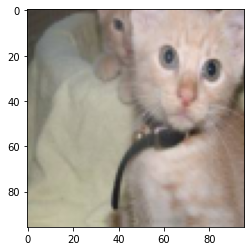

In [63]:
predict_single(*test_dataset[42])

Actual : panda  | Predicted : panda


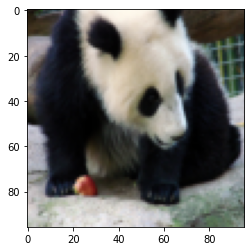

In [64]:
predict_single(*test_dataset[175])

Actual : panda  | Predicted : panda


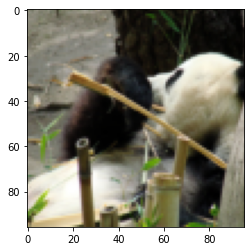

In [65]:
predict_single(*test_dataset[33])

In [30]:
# Final Test dataset evaluation
test_dl = DeviceDataLoader(test_dl, device)
res = evaluate(model, test_dl)
res

{'val_loss': 0.4447147250175476, 'val_acc': 0.8556463122367859}

**Test accuracy: 87.6%**

In [117]:
torch.save(model.state_dict(), 'animals-resnet.pth')

### Further testing

In [29]:
model = ResNet(3,3)
model.load_state_dict(torch.load('animals-resnet.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


dogs


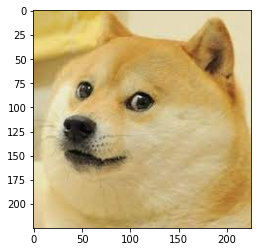

In [218]:
def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

model_ft = model
model_ft.eval()



#print(np.argmax(model_ft(image_loader(transforms_val, "zubayer.jpg")).detach().numpy()))

def testOutput(imageName):
  outIndex = np.argmax(model_ft(image_loader(transforms_val, imageName)).detach().numpy())
  print(dataset.classes[outIndex])
  plt.imshow(Image.open(imageName))
  

testOutput("download.jpg")

## Streamlit App

In [252]:
!./ngrok authtokens "2FYzJSlnKfPQmdI9YaFY5qrezJ7_37ayzZuV5gcMLseZh8t5G"
!pip install pyngrok

/bin/bash: ./ngrok: No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [260]:
from pyngrok import ngrok 
public_url = ngrok.connect(port='8501')
public_url

<NgrokTunnel: "http://b273-34-86-161-127.ngrok.io" -> "http://localhost:80">

In [254]:
%%writefile streamlit_app.py 
import streamlit as st 
st.markdown(""" This is a Streamlit App """)

Overwriting streamlit_app.py


In [259]:
!streamlit run streamlit_app.py --server.port=8501


2022-10-02 04:50:54.094 INFO    numexpr.utils: NumExpr defaulting to 2 threads.



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.86.161.127:8501

  Stopping...
  Stopping...
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 2036, in shutdown
    h.flush()
  File "/usr/lib/python3.7/logging/__init__.py", line 1002, in flush
    def flush(self):
  File "/usr/local/lib/python3.7/dist-packages/streamlit/web/bootstrap.py", line 67, in signal_handler
    server.stop()
  File "/usr/local/lib/python3.7/dist-packages/streamlit/web/server/server.py", line 318, in stop
    self._runtime.stop()
  File "/usr/local/lib/python3.7/dist-packages/streamlit/runtime/runtime.py", line 281, in stop
    async_objs.eventloop.call_soon_threadsafe(stop_on_eventloop)
  File "/usr/lib/python3.7/asyncio/base_events.py", line 736, in call_soon_threadsafe
    self._check_cl

In [251]:
! streamlit run streamlit_app.py & npx localtunnel --port 8501

2022-10-02 04:48:30.828 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
npx: installed 22 in 1.927s


your url is: https://twelve-tables-begin-34-86-161-127.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.86.161.127:8501

  Stopping...
^C
